In [ ]:
import subtractr
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import circuitmap
from circuitmap.neural_waveform_demixing import NeuralDemixer
from circuitmap.simulation import simulate_continuous_experiment
import subtractr.photocurrent_sim as pcsim
from subtractr.photocurrent_sim import sample_jittered_photocurrent_shapes, split_overlapping, monotone_decay_filter
from tqdm import tqdm

In [ ]:
stim_dur_ms=5
prior_context=100
response_length=4000
stim_freq=50
N=100
sampling_freq=20000
expt = simulate_continuous_experiment(N=N, stim_freq=stim_freq, expt_len=int(10 * 20000),
                                      prior_context=prior_context, response_length=response_length,)

In [ ]:
def _nonnegsvd_init(traces, rank=1):
    U, S, V = jnp.linalg.svd(traces, full_matrices=False)
    U = U[:, :rank] * S[:rank]
    V = V[:rank, :]

    U_plus = jnp.maximum(U, 0)
    U_minus = jnp.maximum(-U, 0)
    V_plus = jnp.maximum(V, 0)
    V_minus = jnp.maximum(-V, 0)

    U = jnp.zeros_like(U)
    V = jnp.zeros_like(V)
    for i in range(rank):
        # Rewrite the above using jax.lax.cond
        
        U = U.at[:, i:i+1].set(
            jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                        U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: U_plus[:, i:i+1],
                lambda x: U_minus[:, i:i+1],
                None
            )
        )
        V = V.at[i:+1, :].set(
            jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                    U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: V_plus[i:i+1, :],
                lambda x: V_minus[i:i+1, :],
                None
            )
        )

    return U, V




In [ ]:
from subtractr.low_rank import _rank_one_nmu, _rank_one_nmu_decreasing

rank_one_nmu = jax.jit(_rank_one_nmu, static_argnames=('update_U', 'update_V', 'baseline', 'stim_start', 'maxiter'))
rank_one_nmu_decreasing = jax.jit(_rank_one_nmu_decreasing,
                                static_argnames=('update_U', 'update_V', 'dec_start', 'maxiter'),)

In [ ]:
import jaxopt
from jaxopt import ProjectedGradient

def pava_jaxopt(x, gamma):
    
    def _objective(y):
        return jnp.sum((x-y)**2)
    
    # make first difference matrix
    N = x.shape[0]
    G = - jnp.eye(N) + jnp.diag(gamma * jnp.ones(N-1), k=1)
    A = jnp.zeros((N,N))
    b = jnp.zeros(N,)
    h = jnp.zeros(N)
    
    projection = lambda y: jaxopt.projection.projection_polyhedron(y, (A, b, G, h), check_feasible=False)
    
    solver = ProjectedGradient(fun=_objective,
                             projection=projection,
                             tol=1e-6, maxiter=100)
    
    y_init = x.copy()
    return solver.run(y_init).params
    
a = np.random.rand(10)
a_fit = pava_jaxopt(a, 0.99)
plt.plot(a)
plt.plot(a_fit)
    

In [ ]:
def add_photocurrents_to_expt(key, expt, pc_shape_params=None,
        frac_pc_cells=0.1, opsin_mean=0.5, opsin_std=0.2,
        stim_dur_ms=5.0, pc_response_var=0.01, pc_window_len_ms=200,
        prior_context=100, response_length=900):
    """Add photocurrents to a continuous experiment generated by circuitmap"""

    # Draw opsin expression from zero-inflated gamma.
    # The vector opsin_expression determines the _average_ amplitude
    # of an evoked photocurrent when stimulating that cell
    N, K = expt['stim_matrix'].shape
    pc_cells = np.random.choice(N, int(frac_pc_cells*N), replace=False)
    opsin_expression = np.zeros(N)
    opsin_expression[pc_cells] = np.random.gamma(shape=(opsin_mean/opsin_std)**2, scale=opsin_std**2/opsin_mean, size=len(pc_cells))
        
    # Draw actual evoked photocurrent heights centered around their average
    pc_contributions = pc_response_var * (
            np.random.randn(N, K) * (opsin_expression[:, None] > 0)) + opsin_expression[:,None]

    if pc_shape_params is None:
        pc_shape_params = dict(
            O_inf_min=0.3,
                O_inf_max=1.0,
                R_inf_min=0.1,
                R_inf_max=1.0,
                tau_o_min=6,
                tau_o_max=25,
                tau_r_min=5,
                tau_r_max=16, 
            )

    pc_full_params = dict(
        onset_jitter_ms=0.01,
        onset_latency_ms=0.0,
        pc_shape_params=pc_shape_params,
        add_target_gp=False,
        target_gp_lengthscale=20,
        target_gp_scale=0.01,
        linear_onset_frac=1.0,
        msecs_per_sample=0.05,
        stim_start=0.0,
        stim_end=stim_dur_ms,
        isi_ms=30,
        window_len_ms=pc_window_len_ms,
    )
   
    # Get a PC shape for every stim
    stim_mat_scaled = expt['stim_matrix'] / np.max(expt['stim_matrix'])
    jittered_pc_shapes = np.array(sample_jittered_photocurrent_shapes(key, K, **pc_full_params)[1])
    true_photocurrents = np.sum(stim_mat_scaled * pc_contributions, axis=0)[:,None] * jittered_pc_shapes
    
    # Add photocurrents to unrolled trace to capture inter-trial overlap
    obs_flat = unfold_to_flat(expt['obs_responses'],
                    response_length=response_length, prior_context=prior_context,
                        stim_freq=stim_freq, sampling_freq=sampling_freq)
    
    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, K * isi, isi) + prior_context
   
    print(stim_times)
    print(true_photocurrents.shape)
    for i,stim_idx in enumerate(stim_times):
        _end_idx = stim_idx + response_length
        end_idx_flat = np.minimum(_end_idx, len(obs_flat))
        end_idx_wrapped = jittered_pc_shapes.shape[1] - np.maximum(_end_idx - len(obs_flat), 0)
        obs_flat[stim_idx:end_idx_flat] += true_photocurrents[i,:end_idx_wrapped]
       
    expt['obs_with_photocurrents'] = fold_overlapping(obs_flat, prior_context, response_length)
    expt['true_photocurrents'] = true_photocurrents
    return expt

def coordinate_descent_nmu(traces,
                           stim_start=100,
                           const_baseline=True,
                           decaying_baseline=True,
                           rank=1,
                           update_U=True,
                           update_V=True,
                           max_iters=100,
                           tol=1e-4,
                           gamma=0.999):

    # Initialize baseline terms on period before stim
    if decaying_baseline:
        U_pre, V_pre = _nonnegsvd_init(traces[:, 0:stim_start], rank=1)
        V_pre_init = jnp.linalg.lstsq(U_pre, traces)[0]
        V_pre = subtractr.pava.pava_decreasing(
            jnp.squeeze(V_pre_init), gamma=gamma)[None, :]
#         _, V_pre, _, max_viol = rank_one_nmu_decreasing(traces, 
#                                                  (U_pre, V_pre_init),
#                                                   update_V=True, update_U=False,
#                                                   gamma=gamma, rho=5.0)
        
        U_photo, V_photo = _nonnegsvd_init(
            np.maximum(traces - U_pre @ V_pre, 0), rank=rank
        )
        U = jnp.concatenate((U_pre, U_photo), axis=1)
        V = jnp.concatenate((V_pre, V_photo), axis=0)
        effective_rank = rank + 1
    else:
        effective_rank = rank
        U, V = _nonnegsvd_init(traces, rank=effective_rank)
    
    if const_baseline:
        beta = jnp.min(traces - U @ V, axis=1, keepdims=True)
        beta = jnp.maximum(0, beta)
    else:
        beta = jnp.zeros((traces.shape[0], 1))

    

    # initialize with SVD and absolute value
#     U, V = _nonnegsvd_init(traces, rank=r)

    loss = jnp.zeros(max_iters)
    for i in tqdm(range(max_iters)):
        if const_baseline:
            beta = jnp.min(traces - U @ V, axis=1, keepdims=True)
            beta = jnp.maximum(beta, 0)

        resid_minus_beta = traces - beta
        for r in range(effective_rank):
            u_curr, v_curr = U[:, r:r+1], V[r:r+1, :]
            resid = resid_minus_beta - U @ V + u_curr @ v_curr

            # treat first component differently if enforcing decaying baseline
            if decaying_baseline and r == 0:
                u_i, v_i, _, _ = rank_one_nmu_decreasing(
                    resid, (u_curr, v_curr), gamma=gamma)
            else:
                u_i, v_i, _, _ = rank_one_nmu(resid, (u_curr, v_curr))

            U = U.at[:, r:r+1].set(u_i)
            V = V.at[r:r+1, :].set(v_i)

        loss = loss.at[i].set(jnp.linalg.norm(traces - U @ V - beta))

    return U, V, beta, loss

def estimate_photocurrents(traces,
                               stim_start=100, stim_end=200, dec_start=500, gamma=0.999):
    """Estimate photocurrents using non-negative matrix underapproximation.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    stim_start : int
        Index of first timepoint of stimulus.
    stim_end : int
        Index of last timepoint of stimulus.
    constrain_V : bool
        If True, constrain the estimated V using the underapprox constraint.
    rank : int
        Rank of the estimated matrix.

    Returns
    -------
    U : array-like
        Estimated U matrix. Shape is (n_traces, rank).
    V : array-like
        Estimated V matrix. Shape is (rank, n_timepoints).
    beta : array-like
        Estimated baseline term. Shape is (n_traces, 1).
    """
    # Create dummy initial factors
    # to use SVD initialization inside _rank_one_nmu
    traces = jnp.maximum(0, traces)
#     U_init = jnp.zeros((traces.shape[0], 1)) * jnp.nan
#     V_init = jnp.zeros((1, stim_end - stim_start)) * jnp.nan

#     U_stim, V_stim, _, _ = rank_one_nmu(traces[:, stim_start:stim_end],
#                                         (U_init, V_init), baseline=True,
#                                         stim_start=100, update_U=True, update_V=True,)

    # Fit 3 terms to the very beginning of the matrix:
    # decaying baseline, constant baseline, and photocurrent
    U_stim, V_stim, beta, loss = coordinate_descent_nmu(
        traces[:,0:stim_end],
        const_baseline=True,
        decaying_baseline=True,
        rank=1,
    )
    
    # The first component of U_stim, V_stim corresponds to the decaying baseline
    traces = traces - beta
    U_dec = U_stim[:,0:1]
    V_dec_full_init = jnp.linalg.lstsq(U_dec, traces)[0]
    _, V_dec, _, _ = rank_one_nmu_decreasing(traces,
                        init_factors=(U_dec, V_dec_full_init),
                        update_U=False, update_V=True,
                        dec_start=0, gamma=gamma)
    # subtract away decaying baseline
    traces = traces - U_dec @ V_dec
    
    # Now fit photocurrent and output estimate.
    # We force our photocurrent estimate to be decreasing after dec_start
    U_photo = U_stim[:, 1:2]
    V_photo = jnp.linalg.lstsq(U_photo, traces[:, stim_start:])[0]

    _, V_photo, _, _ = rank_one_nmu_decreasing(traces[:, stim_start:],
                        init_factors=(U_photo, V_photo),
                        update_U=False, update_V=True, dec_start=dec_start, gamma=gamma)
    
#     _, V_photo, _, _ = rank_one_nmu(traces[:, stim_start:], init_factors=(U_photo, V_photo),
#                                     baseline=False,
#                                    update_U=False, update_V=True)
    
    # pad V with zeros to account for the time before stim_start
    V_photo = jnp.concatenate((jnp.zeros((1, stim_start)), V_photo), axis=1)
    return U_photo, V_photo, U_dec, V_dec, beta

def fold_overlapping(trace, prior_context, response_length):
    """
    Split trace into overlapping segments of length response_length.
    prior_context determines the amount which is overlapped from the prior trial
    """
    num_samples = trace.shape[0]
    isi = int(sampling_freq / stim_freq)
    start_indices = np.arange(0, num_samples - response_length + prior_context, isi)

    end_indices = start_indices + response_length
    return np.array([trace[x:y] for x,y in zip(start_indices, end_indices)])

def unfold_to_flat(traces, response_length=900, prior_context=100, stim_freq=30, sampling_freq=20000):
    response_length = traces.shape[1]
    
    next_stim_idx = prior_context + int(sampling_freq / stim_freq)
    next_stim_idx = np.minimum(next_stim_idx, response_length-1)
    
        
    # include prior context on first trace, after that we leave it off
    flattened = np.concatenate(traces[:, prior_context:next_stim_idx])
    flattened = np.concatenate((traces[0, 0:prior_context], flattened, traces[-1,next_stim_idx:]))
    
    return flattened
    
    
def subtract_overlapping_trials(orig, est,
            prior_context=100, stim_freq=30, sampling_freq=20000):
    
    
    # compute stim times based on prior context and response length
    num_stims, response_length = orig.shape
    
    obs_flat = unfold_to_flat(orig, response_length=response_length,
                    prior_context=prior_context, stim_freq=stim_freq,
                              sampling_freq=sampling_freq)
    

    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, num_stims * isi, isi)
   
    num_samples = obs_flat.shape[0]
    subtracted_flat = obs_flat.copy()
    for stim_idx, pc_est in zip(stim_times, est):
        end_idx = stim_idx + response_length
        
        # check whether we're at the end of the trace
        if end_idx > num_samples:
            import pdb; pdb.set_trace()
            est_cutoff = end_idx - num_samples
            end_idx = num_samples
            subtracted_flat[stim_idx:end_idx] -= pc_est[:est_cutoff]
            
#             len_remaining = num_samples - stim_idx
#             subtracted_flat[stim_idx:] = pc_est[prior_context:prior_context + len_remaining]
            continue
        else:
            subtracted_flat[stim_idx:end_idx] -= pc_est
    subtracted = fold_overlapping(subtracted_flat, prior_context, response_length)
    return subtracted


In [6]:
key = jax.random.PRNGKey(0)
expt = add_photocurrents_to_expt(key, expt, stim_dur_ms=stim_dur_ms,
    prior_context=prior_context, response_length=response_length,
                                 frac_pc_cells=0.05,
                                 pc_window_len_ms=(response_length / sampling_freq * 1e3))

# run subtraction
U_photo, V_photo, U_dec, V_dec, beta = estimate_photocurrents(expt['obs_with_photocurrents'],
                             stim_start=prior_context,
                             stim_end=prior_context+100,
                             dec_start=600,
                             gamma=0.9995,)
photo_est = U_photo @ V_photo
base_est = U_dec @ V_dec + beta

[   100    500    900   1300   1700   2100   2500   2900   3300   3700
   4100   4500   4900   5300   5700   6100   6500   6900   7300   7700
   8100   8500   8900   9300   9700  10100  10500  10900  11300  11700
  12100  12500  12900  13300  13700  14100  14500  14900  15300  15700
  16100  16500  16900  17300  17700  18100  18500  18900  19300  19700
  20100  20500  20900  21300  21700  22100  22500  22900  23300  23700
  24100  24500  24900  25300  25700  26100  26500  26900  27300  27700
  28100  28500  28900  29300  29700  30100  30500  30900  31300  31700
  32100  32500  32900  33300  33700  34100  34500  34900  35300  35700
  36100  36500  36900  37300  37700  38100  38500  38900  39300  39700
  40100  40500  40900  41300  41700  42100  42500  42900  43300  43700
  44100  44500  44900  45300  45700  46100  46500  46900  47300  47700
  48100  48500  48900  49300  49700  50100  50500  50900  51300  51700
  52100  52500  52900  53300  53700  54100  54500  54900  55300  55700
  5610

100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


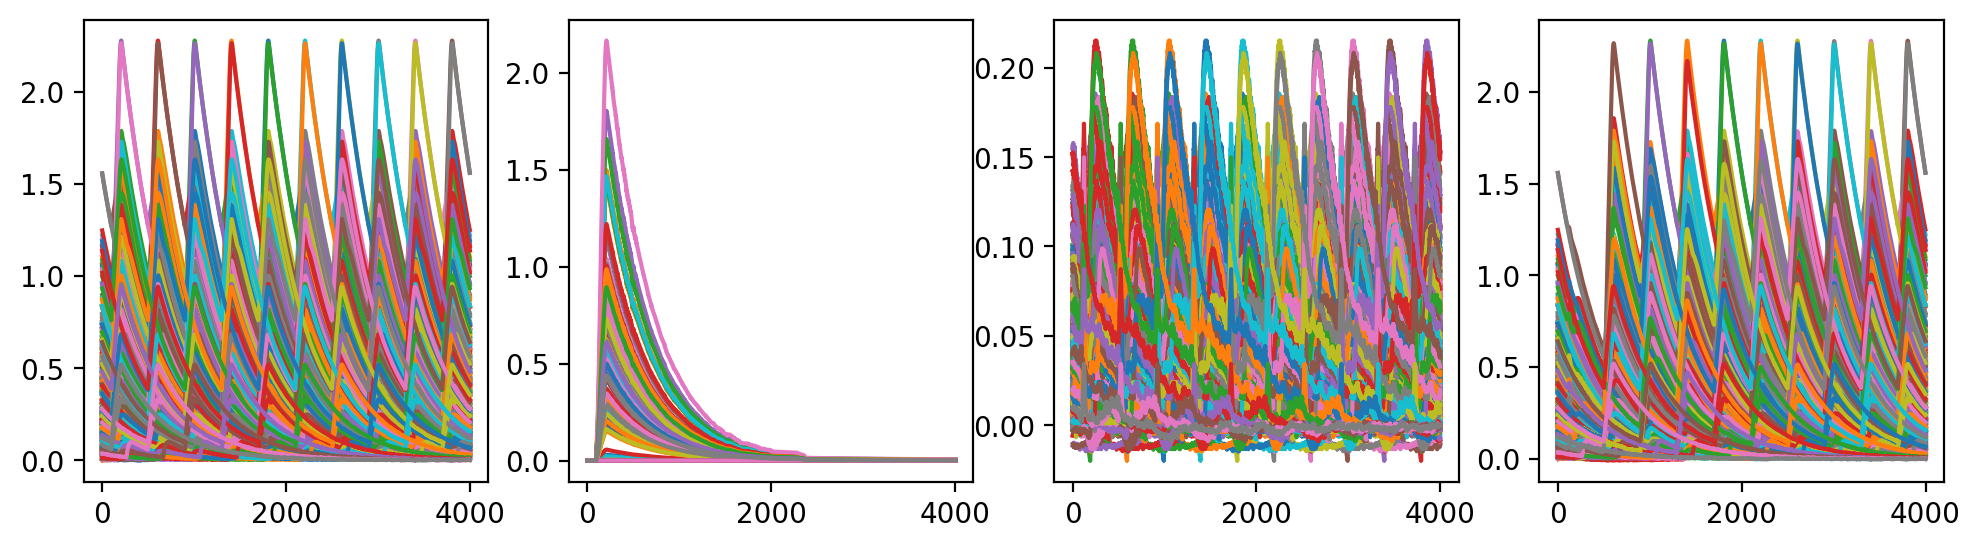

In [8]:
subtracted = subtract_overlapping_trials(expt['obs_with_photocurrents'], photo_est,
                    prior_context=prior_context, stim_freq=stim_freq,)

fig, axs = plt.subplots(1, 4, figsize=(12,3), dpi=200)
axs[0].plot(expt['obs_with_photocurrents'].T)
axs[1].plot(photo_est.T)
axs[2].plot(subtracted.T)
axs[3].plot((expt['obs_with_photocurrents'] - photo_est).T)
plt.show()

In [9]:
jax.devices("gpu")

[GpuDevice(id=0, process_index=0)]

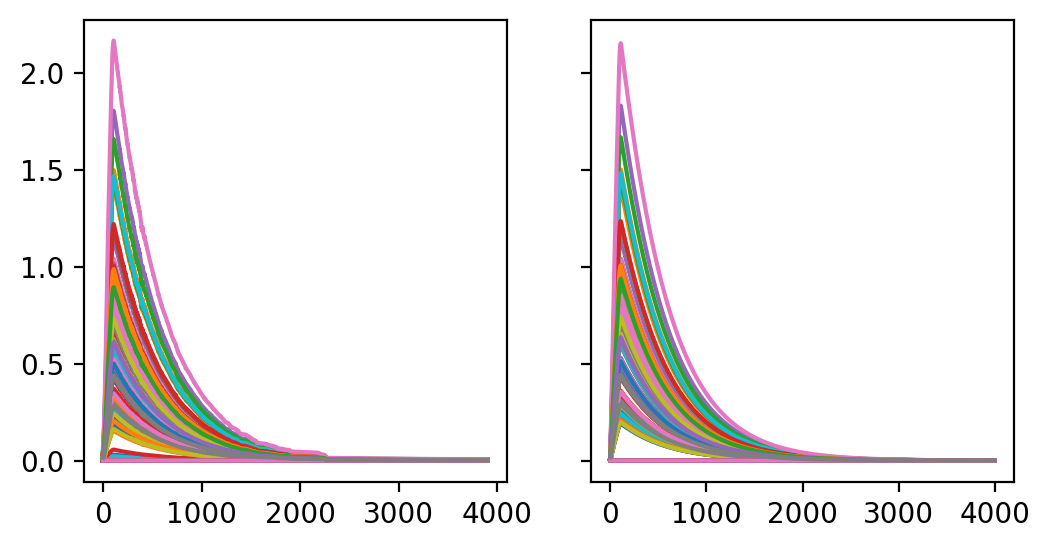

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200, sharey=True)
axs[0].plot(photo_est[:, prior_context:].T)
axs[1].plot(expt['true_photocurrents'].T)
plt.show()

## Comparing previous trial strategies
- strategy 1: use overlapping window to subtract next-trial effects
- strategy 2: estimate previous trial effects using only a small amount of prior context

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v1.9.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt`


Demixing PSC traces... complete (elapsed time 0.04s, device=cuda).
Demixing PSC traces... complete (elapsed time 0.03s, device=cuda).
Demixing PSC traces... complete (elapsed time 0.03s, device=cuda).
Demixing PSC traces... complete (elapsed time 0.03s, device=cuda).


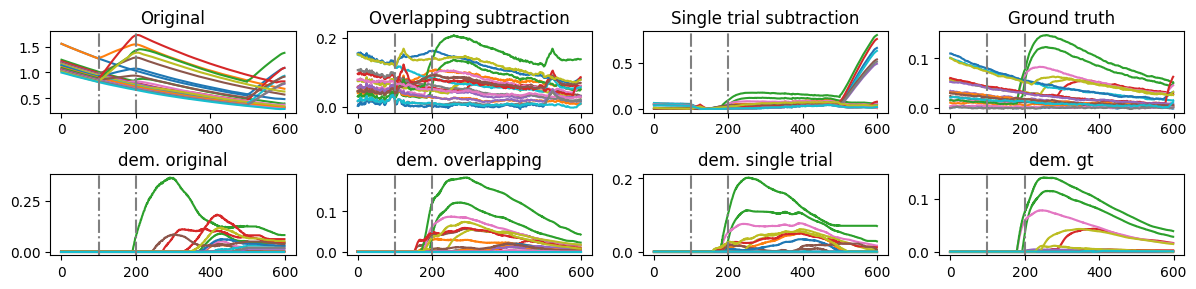

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,3))
plot_start = prior_context - 100
plot_end = prior_context + 500

# For this comparison, we'll most likely see differences between the two strategies
# on trials which have a larger transient at the beginning of the trial, so subset to those for now.
idxs = np.argsort(
    np.sum(
        expt['obs_with_photocurrents'][:,0:prior_context],
        axis=-1,
    )
)[::-1]
top_idxs = idxs[0:20]

axs[0,0].plot(expt['obs_with_photocurrents'][top_idxs,0:plot_end].T)
axs[0,0].set_title('Original')

axs[0,1].plot(subtracted[top_idxs, plot_start:plot_end].T)
axs[0,1].set_title('Overlapping subtraction')

single_trial_subtracted = expt['obs_with_photocurrents'] - photo_est - base_est
axs[0,2].plot(single_trial_subtracted[top_idxs, plot_start:plot_end].T)
axs[0,2].set_title('Single trial subtraction')

axs[0,3].plot(expt['obs_responses'][top_idxs,plot_start:plot_end].T)
axs[0,3].set_title('Ground truth')

# plot results after demixing
demixer = NeuralDemixer(path='../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt')
demixed_original = demixer(np.array(expt['obs_with_photocurrents'][:, 0:900]))
demixed_overlapping = demixer(np.array(subtracted[:, 0:900]))
demixed_singletrial = demixer(np.array(single_trial_subtracted[:, 0:900]))
demixed_gt = demixer(np.array(expt['obs_responses'][:, 0:900]))

axs[1,0].plot(demixed_original[top_idxs,0:plot_end].T)
axs[1,0].set_title('dem. original')

axs[1,1].plot(demixed_overlapping[top_idxs, plot_start:plot_end].T)
axs[1,1].set_title('dem. overlapping')

axs[1,2].plot(demixed_singletrial[top_idxs, plot_start:plot_end].T)
axs[1,2].set_title('dem. single trial')

axs[1,3].plot(demixed_gt[top_idxs,plot_start:plot_end].T)
axs[1,3].set_title('dem. gt')

for ax in axs.ravel():
    ax.axvline(x=100, linestyle='-.', color='grey')
    ax.axvline(x=200, linestyle='-.', color='grey')

plt.tight_layout()
plt.show()

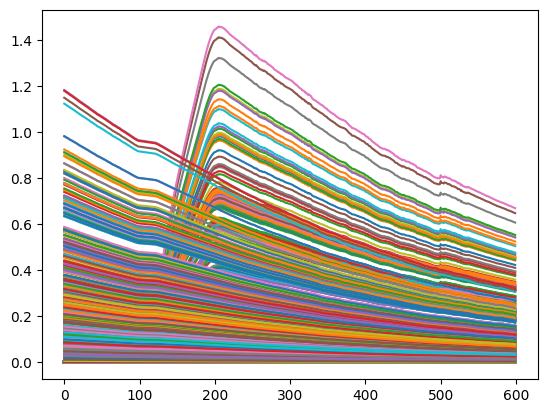

In [21]:
plt.plot(photo_est[:, plot_start:plot_end].T)
plt.plot(base_est[:,plot_start:plot_end].T)
plt.show()

100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


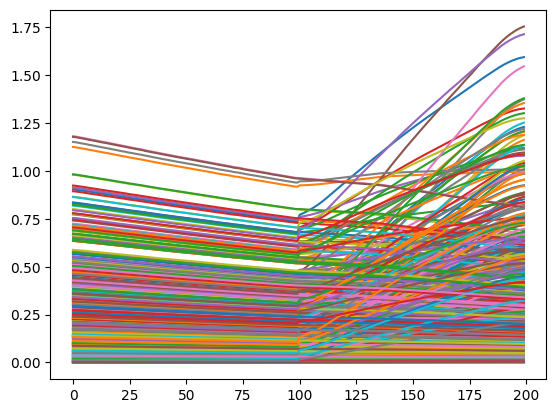

In [12]:
traces = expt['obs_with_photocurrents']
stim_end=200
U_stim, V_stim, beta, loss = coordinate_descent_nmu(
        traces[:,0:stim_end],
        const_baseline=True,
        decaying_baseline=True,
        rank=1,
        max_iters=2,
    )
plt.plot((U_stim @ V_stim + beta).T)
plt.show()

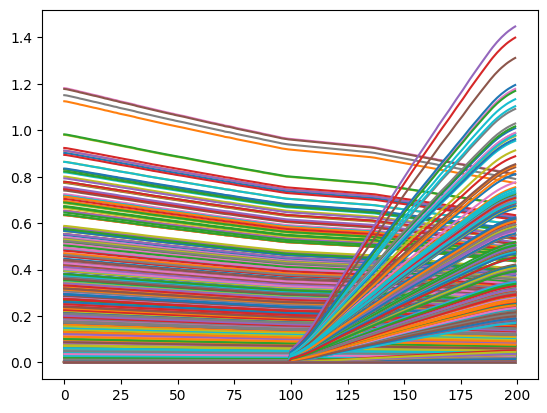

In [13]:
plt.plot((U_stim[:,0:1] @ V_stim[0:1,:]).T, )
plt.plot((U_stim[:,1:2] @ V_stim[1:2,:]).T,)
# plt.plot(expt['obs_with_photocurrents'][:,0:200].T, color='blue', alpha=0.4)
plt.show()

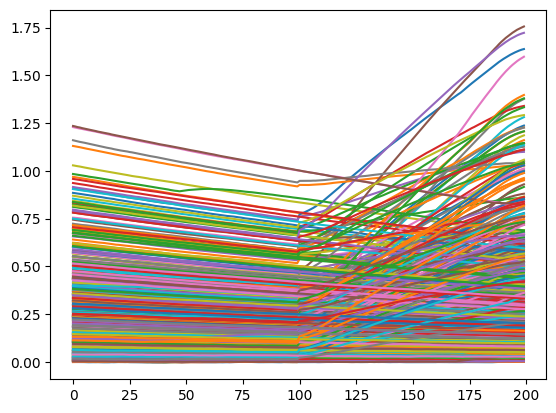

In [14]:
plt.plot(expt['obs_with_photocurrents'][:,0:200].T)
plt.show()

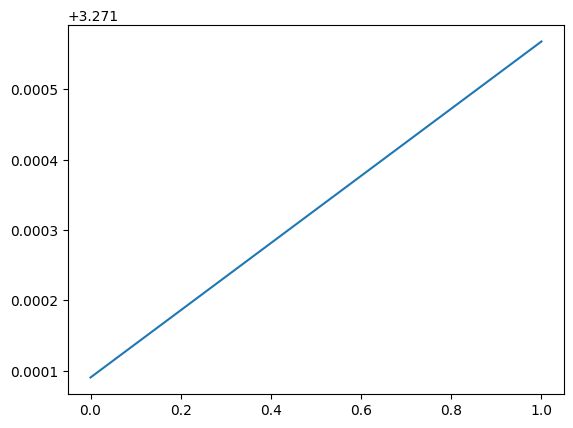

In [15]:
plt.plot(loss)

In [16]:
loss

DeviceArray([3.27109043, 3.27156766], dtype=float64)